# Computer Vision and OpenCV

This notebook is a part of [AI for Beginners Curriculum](http://aka.ms/ai-beginners).

[OpenCV](https://opencv.org/) is considered to be *de facto* standard for image processing. It contains a lot of useful algorithms, implemented in C++. You can call OpenCV from Python as well.

In this notebooks, we will give you some examples for using OpenCV. For more details, you can visit [Learn OpenCV](https://learnopencv.com/getting-started-with-opencv/) online course. 

First, let's `import cv2`, as well as some other useful libraries:

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()


## Loading Images

Images in Python can be conveniently represented by NumPy arrays. For example, grayscale image with size of 320x200 pixels would be stored in 200x320 array, and color image of the same dimension would have shape of 200x320x3 (for 3 color channels). 

Let's start by loading an image:

(242, 531, 3)


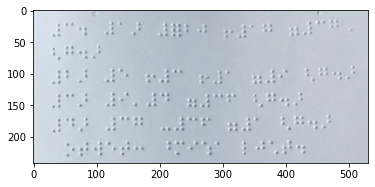

In [2]:
im = cv2.imread('data/braille.jpeg')
print(im.shape)
plt.imshow(im)

As you can see, it is an image of braille text. Since we are not very interested in the actual color, we can convert it to black-and-white:

(242, 531)


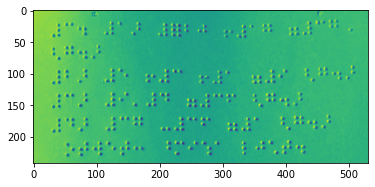

In [98]:
bw_im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
print(bw_im.shape)
plt.imshow(bw_im)

## Braille Image Processing

If we want to apply image classification to recognize the text, we need to cut out individual symbols to make them similar to MNIST images that we have seen before. This can be done using [object detection](../11-ObjectDetection/README.md) technique which we will discuss later, but also we can try to use pure computer vision for that. A good description of how computer vision can be used for character separation can be found [in this blog post](https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) - we will only focus on some computer vision techniques here.

First, let's try to enhance the image a little bit. We can use the idea of **thresholding** (well described [in this OpenCV article](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)): 

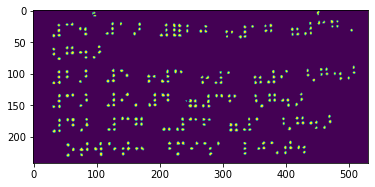

In [99]:
im = cv2.blur(bw_im,(3,3))
im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                           cv2.THRESH_BINARY_INV, 5, 4)
im = cv2.medianBlur(im, 3)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
im = cv2.GaussianBlur(im, (3,3), 0)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
plt.imshow(im)

To work with images, we need to "extract" individual dots, i.e. convert the images to a set of coordinates of individual dots. We can do that using **feature extraction** techniques, such as SIFT, SURF or [ORB](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html):

In [100]:
orb = cv2.ORB_create(5000)
f,d = orb.detectAndCompute(im,None)
print(f"First 5 points: { [f[i].pt for i in range(5)]}")

First 5 points: [(307.20001220703125, 40.80000305175781), (297.6000061035156, 114.00000762939453), (423.6000061035156, 133.20001220703125), (242.40000915527344, 144.0), (103.68000793457031, 57.60000228881836)]


Let's plot all points to make sure we got things right:

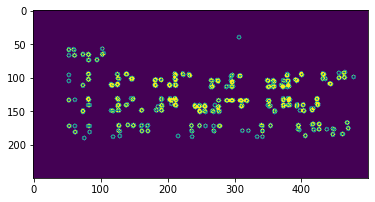

In [109]:
def plot_dots(dots):
    img = np.zeros((250,500))
    for x in dots:
        cv2.circle(img,(int(x[0]),int(x[1])),3,(255,0,0))
    plt.imshow(img)

pts = [x.pt for x in f]
plot_dots(pts)  

To separate individual characters, we need to know the bounding box of the whole text. To find it out, we can just compute min and max coordinates: 

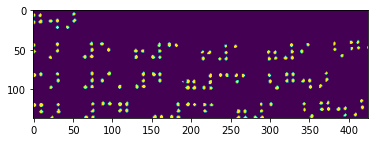

In [120]:
min_x, min_y, max_x, max_y = [int(f([z[i] for z in pts])) for f in (min,max) for i in (0,1)]
min_y+=13
plt.imshow(im[min_y:max_y,min_x:max_x])

Also, this text can be partially rotated, and to make it perfectly aligned we need to do so-called **perspective transformation**. We will take a rectangle defined by points $(x_{min},y_{min}), (x_{min},y_{max}), (x_{max},y_{min}), (x_{max},y_{max})$ and align it with new image with proportional dimensions:

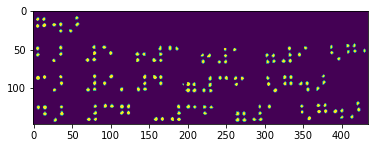

In [122]:
off = 5
src_pts = np.array([(min_x-off,min_y-off),(min_x-off,max_y+off),
                    (max_x+off,min_y-off),(max_x+off,max_y+off)])
w = int(max_x-min_x+off*2)
h = int(max_y-min_y+off*2)
dst_pts = np.array([(0,0),(0,h),(w,0),(w,h)])
ho,m = cv2.findHomography(src_pts,dst_pts)
trim = cv2.warpPerspective(im,ho,(w,h))
plt.imshow(trim)

After we get this well-aligned image, it should be relatively easy to slice it into pieces:

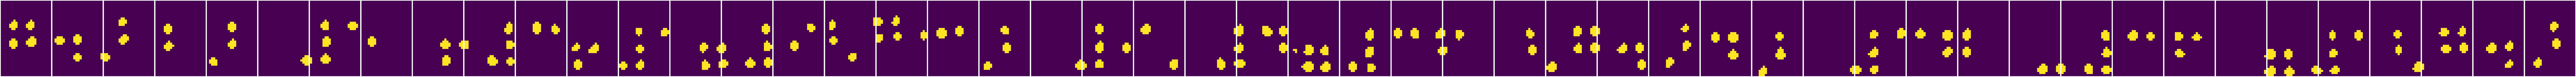

In [164]:
char_h = 36
char_w = 24
def slice(img):
    dy,dx = img.shape
    y = 0
    while y+char_h<dy:
        x=0
        while x+char_w<dx:
            # Skip empty lines
            if np.max(img[y:y+char_h,x:x+char_w])>0:
                yield img[y:y+char_h,x:x+char_w]
            x+=char_w
        y+=char_h

sliced = list(slice(trim))
display_images(sliced)

You have seen that quite a lot of tasks can be done using pure image processing, without any artificial intelligence. If we can use computer vision techniques to make the work of a neural network simpler - we should definitely do it, because it will allow us to solve problems with smaller number of training data.

## Motion Detection using Frame Difference

Detecting motion on video stream is a very frequent task. For example, it allows us to get alerts when something happens on a surveillance camera. If we want to understand what's happening on the camera, we can then use a neural network - but it is much cheaper to use neural network when we know that something is going on.

The main idea of motion detection is simple. If the camera is fixed, then frames from the camera should be pretty similar to each other. Since frames are represented as arrays, just by subtracting those arrays for two subsequent frames we will get the pixel difference, which should be low for static frames, and become higher once there is substantial motion in the image.

We will start by learning how to open a video and convert it into a sequence of frames:  

Total frames: 876


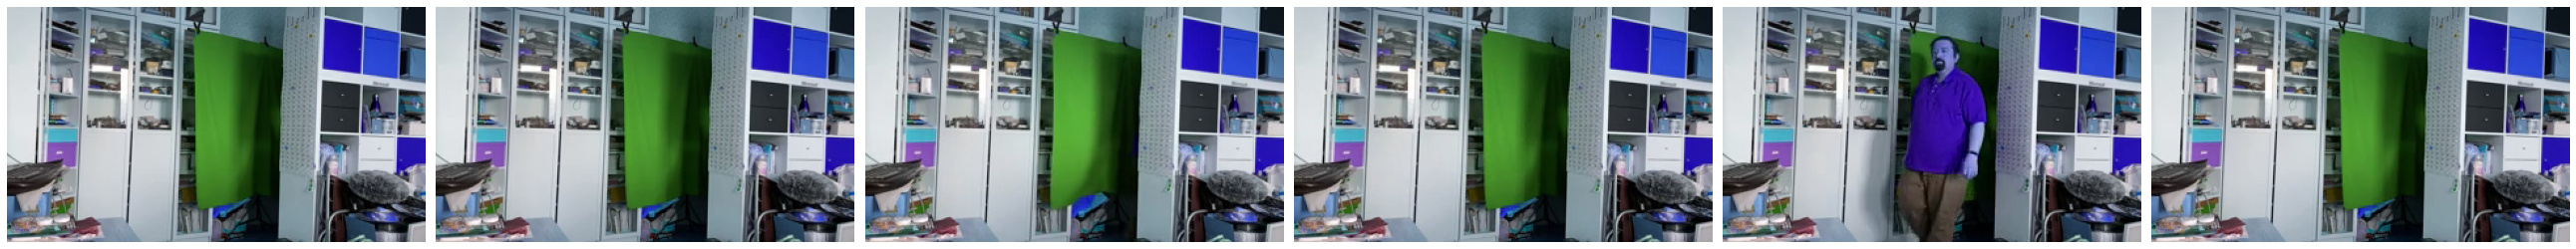

In [42]:
vid = cv2.VideoCapture('data/motionvideo.mp4')

c = 0
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)
    c+=1
vid.release()
print(f"Total frames: {c}")
display_images(frames[::150])

Since color is not so important for motion detection, we will convert all frames to grayscale. Then, we will compute the frame differences, and plot their norms to visually see the amount of activity going on: 

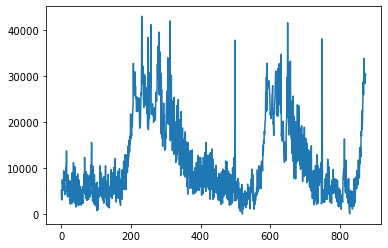

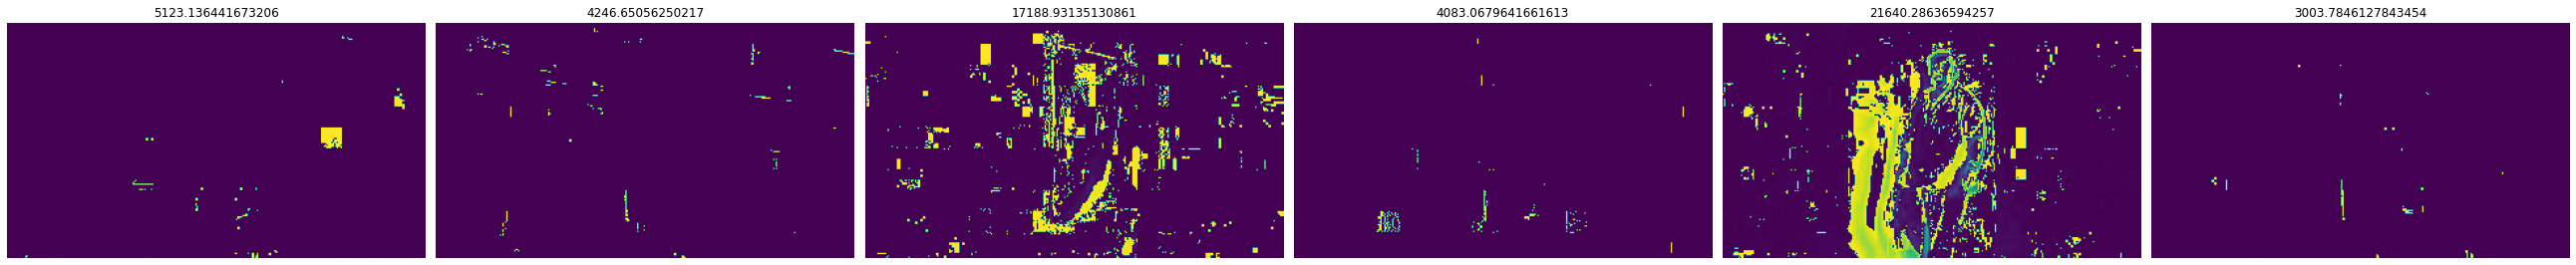

In [56]:
bwframes = [cv2.cvtColor(x,cv2.COLOR_BGR2GRAY) for x in frames]
diffs = [(p2-p1) for p1,p2 in zip(bwframes[:-1],bwframes[1:])]
diff_amps = np.array([np.linalg.norm(x) for x in diffs])
plt.plot(diff_amps)
display_images(diffs[::150],titles=diff_amps[::150])

Suppose we want to create a report that shows what happened in front of the camera by showing the suitable image each time something happens. To do it, we probably want to find out the start and end frame of an "event", and display the middle frame. To remove some noise, we will also smooth out the curve above with moving average function: 

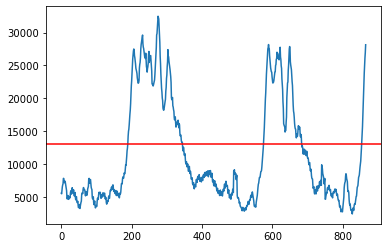

In [57]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

threshold = 13000

plt.plot(moving_average(diff_amps,10))
plt.axhline(y=threshold, color='r', linestyle='-')

Now we can find out frames that have the amount of changes above the threshold by using `np.where`, and extract a sequence of consecutive frames that is longer than 30 frames: 

In [149]:
active_frames = np.where(diff_amps>threshold)[0]

def subsequence(seq,min_length=30):
    ss = []
    for i,x in enumerate(seq[:-1]):
        ss.append(x)
        if x+1 != seq[i+1]:
            if len(ss)>min_length:
                return ss
            ss.clear()

sub = subsequence(active_frames)
print(sub)


[195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322]


And finally we can display the image:

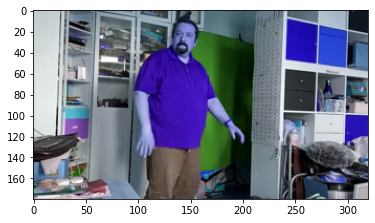

In [150]:
plt.imshow(frames[(sub[0]+sub[-1])//2])

You may notice that color scheme on this image does not look right! This is because OpenCV for historical reasons loads images in BGR color space, while matplotlib uses more traditional RGB color order. Most of the time, it makes sense to convert images to RGB immediately after loading them. 

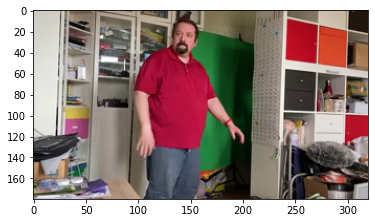

In [151]:
plt.imshow(cv2.cvtColor(frames[(sub[0]+sub[-1])//2],cv2.COLOR_BGR2RGB))

## Extract Motion using Optical Flow

While just comparing two consecutive frames allows us to see the amount of changes, it does not give any information on what is actually moving and where. To get that information, there is a technique called **[optical flow](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html)**:

* **Dense Optical Flow** computes the vector field that shows for each pixel where is it moving
* **Sparse Optical Flow** is based on taking some distinctive features in the image (eg. edges), and building their trajectory from frame to frame.

Read more on optical flow [in this great tutorial](https://learnopencv.com/optical-flow-in-opencv/).

Let's compute dense optical flow between our frames:

In [152]:
flows = [cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 3, 15, 3, 5, 1.2, 0) 
         for f1,f2 in zip(bwframes[:-1],bwframes[1:])]
flows[0].shape

(180, 320, 2)

As you can see, for each frame the flow has the dimension of the frame, and 2 channels, corresponding to x and y components of optical flow vector.

Displaying optical flow in 2D is a bit challenging, but we can use one clever idea. If we convert optical flow to polar coordinates, then we will get two components for each pixel: *direction* and *intensity*. We can represent intensity by the pixel intensity, and direction by different colors. We will create an image in [HSV (Hue-Saturation-Value) color space](https://en.wikipedia.org/wiki/HSV_color_space), where hue will be defined by direction, value - by intensity, and saturation will be 255. 

195 322


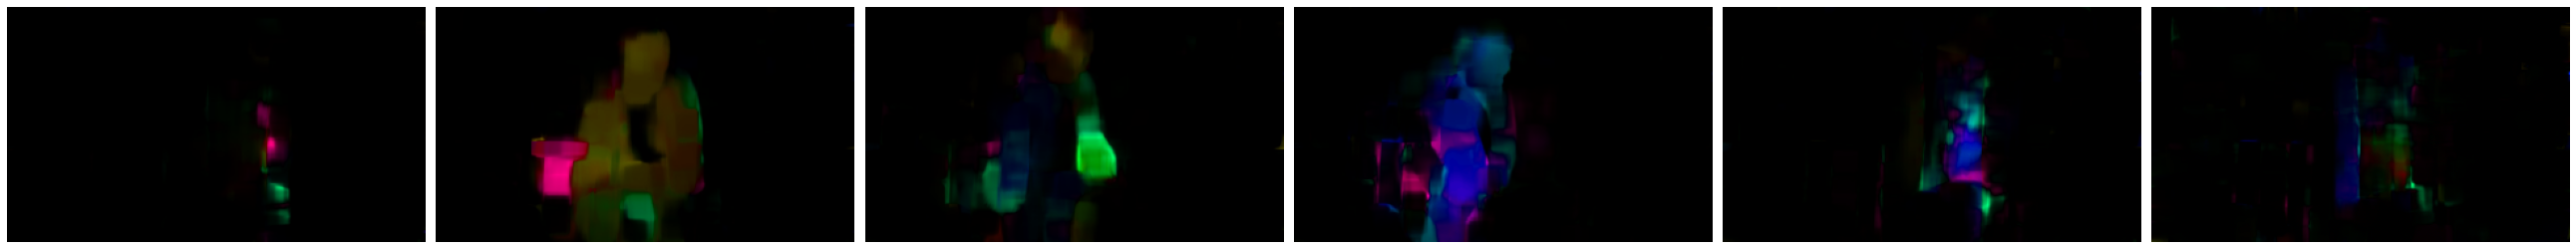

In [158]:
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)

start = sub[0]
stop = sub[-1]
print(start,stop)

frms = [flow_to_hsv(x) for x in flows[start:stop]]
display_images(frms[::25])

So, in those frames greenish color corresponds to moving to the left, while blue - moving to the right.

Optical flow can be a great tool to draw conclusions about general direction of movement. For example, if you see that all pixels in a frame are moving in more or less one direction - you can conclude that there is camera movement, and try to compensate for that.